In [1]:
#Загружаем библиотеки
#%matplotlib inline
import mne
import numpy as np
from mne.preprocessing import (ICA,read_ica)
import scipy.linalg as la
import scipy.signal as sn
from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif as mif
from sklearn.feature_selection import mutual_info_regression as mir
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.io import loadmat
from sklearn.svm import SVC as SVM
from matplotlib import pyplot as plt

from pathlib import Path

#раскомментируете, если необходимо получать интерактивные графики!!!
#%matplotlib qt

#import matplotlib
#matplotlib.rcParams.update({'font.size': 16})

In [37]:
#Фильтер-банк csp - класс, позволяющий загружать mne-raw структуру, находить фильтры csp, для набора
#частотных диапазонов, находить наилучшие фильтры и диапазоны, запоминать их и применять к новым данным,
#сразу выделяя признаки. Может использоваться как обычный csp, для этого нужно указать только один
#частотный диапазон, и количество признаков (n_feature), равное количеству фльтров (filter_idc)
class fbCSP:
    
    def __init__(self,events_id,freq_range,\
                 filters_idc = [0,1,-1,-2],dim_red = None,n_features = None,scale = 1):
        #events_id - метки событий, которые интересуют (7, 8, 9, 10 - вображение левой рукой, правой,
        #ногами, языком), freq_range np.shape(freq_range) = N_bands x 2, значения в первом столбце -
        #нижние частоты среза, во втором - верхние, filter_idc - индексы фильтров, которые хотим учитывать,
        #с учетом того, что 0 фильтр - соответствует самой синхронизирующейся компоненте, последний
        #-  самой десинхронизирующейся, то есть нас как правило интересуют крайние фильтры
        #dim_red - выполнять ли понижение размерности. Если делали ICA, то нужно обязательно
        #понизить размерность до числа, равного количеству каналов минус количество удалённых компонент
        #n_features - какое количество признаков (для каждого класса) использовать в итоге,
        #среди всех фильтров и полос частот, scale  масштабирование данных для удобства
        
        self.freq_range = freq_range
        self.Nbands = freq_range.shape[0]
        self.filters_idc = filters_idc
        self.Nclasses = len(events_id)
        self.n_filters = len(filters_idc)
        self.dim_red = dim_red
        self.n_features = n_features
        self.events_id = events_id
        self.scale = scale
    
    #тут происходит обучение csp - нахождение и запоминание фильтров и отбор среди них значимых
    def fit(self,raw,tmin,tmax):
        
        #raw - mne raw структура, tmin, tmax - начало и конец временного отрезка после начала стимула,
        #который нас интересует, для эпохирования данных
        
        #загружаем список всех собтый для дальнейшей работы
        events,buf= mne.events_from_annotations(raw)
        
        #если мы задали понижение размерности, то находим и запоминаем матрицу pca преобразования
        #если понижение размерности не нужно, просто присваиваем матрице PCA единичную матрицу
        if self.dim_red:
            data = raw.get_data(reject_by_annotation = 'omit')
            self.pca_w,s,v = la.svd(data,full_matrices = False)
            self.pca_w = self.pca_w[:,:self.dim_red]
        else:
            data = raw.get_data(reject_by_annotation = 'omit')
            self.pca_w = self.pca_w[:,:self.dim_red] = np.eye(data.shape[0])
         
        #Эпохируем данные и делаем прочее, чтобы просто вытянуть нужную информацию - количество трайалов
        #количество отсчетов в одном трайале, и т д..
        epochs = mne.Epochs(raw,events = events,event_id =self.events_id,\
                            tmin=tmin,tmax=tmax,event_repeated = 'drop',baseline = None)
    
        events = epochs.events
        data = epochs.get_data()
        del epochs
        
        nT = data.shape[2]
        if self.dim_red:
            self.Nch = self.dim_red
        else:
            self.Nch = data.shape[1]
      
        Ntrials = data.shape[0]
        
        #создаём структуру, которая будет запоминать фильтры csp (все, а не только лучшие)
        self.w = np.ndarray((self.Nclasses,self.n_filters*self.Nbands,self.Nch))
        
        #создаем структуру для запоминания признаков
        features = np.ndarray((self.Nclasses,Ntrials,self.n_filters*self.Nbands))
        
        #массив значений взаимной информации признаков с классами, для отбора лучших фильтров
        MI = np.ndarray((self.Nclasses,self.n_filters*self.Nbands))
        #индексы фильтров для каждого класса в порядке убывания значимости
        self.feat_idc = np.ndarray((self.Nclasses,self.n_filters*self.Nbands),dtype = 'int')
        
        counter = 0
        for i in range(self.Nbands):
            #фильтрация происходить IN PLACE, а данные нужно фильтовать несколько раз подряд во всех
            #заданных частотных диапазонах, поэтому делаем копию, и работаем с ней на каждой итерации
            raw_copy = raw.copy()
            raw_copy.filter(self.freq_range[i,0],self.freq_range[i,1],method = 'iir')
            
            #эпохируем данные, преобразовываем в numpy array, вычитаем среднее, запоминанем список меток
            #для всех эпох
            epochs = mne.Epochs(raw_copy,events = events,event_id=self.events_id,tmin=tmin,
                                                        tmax=tmax,baseline = None)
            data = epochs.get_data()
            data = data -np.mean(data,axis = 2)[:,:,np.newaxis]
            labels = epochs.events[:,2]
            
            #запоминаем средние ковариации всех классов
            covs = np.ndarray((self.Nclasses,self.Nch,self.Nch))
            for j in range(self.Nclasses):
                #вырезаем только эпохи для j-того класса
                data_event = data[labels==self.events_id[j]]
                #делаем понижение размерности
                data_event = self.pca_w.T@data_event
                #считаем среднюю ковариацию для данного класса
                covs[j] = np.sum(data_event@data_event.transpose(0,2,1),axis = 0)/\
                    (nT*data_event.shape[0])
        
            #plt.figure(dpi = 300)     
            #plt.xlabel('Number of eigenvalue')
            #plt.ylabel('Value')
        
            #средняя ковариация по всем классам
            common_cov = np.mean(covs,axis  = 0)
            
            #для каждого класса находитм фильтры csp, по схеме ковариация данного класса versus 
            #средние ковариации по всем классам
            for j in range(self.Nclasses):
                l,w = la.eig(covs[j],common_cov)
                
                #plt.plot(np.arange(1,l.shape[0]+1),np.sort(l)[::-1])
                
                #сортируем собственные векторы так, что соответствующие собственные числа монотонно убывают
                w = w[:,np.argsort(np.abs(l))[::-1]]
                
                if (j == 1):
                     #топографии фильтров
                     Z = np.linalg.inv(w)
                #     x1 = w[:,-2]@self.pca_w.T@data[labels ==8]
                #     x2 = w[:,-2]@self.pca_w.T@data[labels ==10]
                #     f,pxx1 = sn.welch(x1,nperseg = 751,axis = 1,fs = 250)
                #     f,pxx2 = sn.welch(x2,nperseg = 751,axis=1,fs = 250)
                #     pxx1 = np.mean(pxx1,axis = 0)
                #     pxx2 = np.mean(pxx2,axis = 0)
                #     plt.figure()
                    
                #     plt.plot(f[20:100],np.log10(pxx2[20:100]))
                #     plt.plot(f[20:100],np.log10(pxx1[20:100]))
                #     plt.xlabel('freq, Hz')
                #     plt.ylabel('spd, dB')
                #     plt.figure()
                    
                #     plt.figure()
                #     plt.plot(np.arange(x2[0,:250].shape[0])*1000/250,x2[0,:250])
                #     plt.plot(np.arange(x1[0,:250].shape[0])*1000/250,x1[0,:250])
                #     plt.xlabel('time, ms')
                #     plt.ylabel('time, amplitude, uV')
                #     plt.figure()
                    
                #выбираем только те фильтры, которые указывали при инициализации 
                w = w[:,self.filters_idc]
                
                #запоминаем их
                self.w[j,counter:counter+len(self.filters_idc)] = w.T
                
                #считаем признаки для каждого фильтра (логарифм суммарной мощности csp-компонент)
                features[j,:,counter:counter+len(self.filters_idc)] = \
                    np.log(np.sum((w.T@self.pca_w.T@data*self.scale)**2,axis = 2))
            
            #plt.legend(['Left Hand','Right Hand','Foot','Tongue'])
            #plt.ylim(0,2)
            counter += len(self.filters_idc)
        
        bin_labels = np.ndarray(labels.shape[0])
        for k in range(self.Nclasses):
       
            
            #бинарные метки для каждого класса для подсчета взаимной информации
            bin_labels[self.events_id[k]==labels] = 1
            bin_labels[self.events_id[k]!=labels] = 0
            
            #считаем взаимную информацию
            MI[k,:] = mif(features[k,:,:],\
                          bin_labels)
                
            #if k == 1:
            #    names = ('Fz','FC3','FC1','FCz',\
            # 'FC2','FC4','C5','C3',\
            # 'C1','Cz','C2','C4','C6',\
            #'CP3','CP1','CPz','CP2',\
            #    'CP4','P1','Pz','P2','POz')
            #    a= np.argmax(MI[k,:])
            #    plt.figure()
            #    weights = Z[-2,:]@self.pca_w.T
            #    names = list()
            
            #    for i in range(weights.shape[0]):
            #        names.append(str(np.round(weights[i],1)))
            #    plt.figure()    
            #    mne.viz.plot_topomap(Z[-2,:]@self.pca_w.T,epochs.info,names = names,show_names = True,sensors = False)
            
            #сортируем признаки в по убыванию взаимной информации с метками классов
            self.feat_idc[k] = np.argsort(MI[k,:])[::-1]
            features[k,:,:]= features[k,:,self.feat_idc[k]].T
            
        #выбираем только первые несколько (сколько - задаётся при инициализации) 
        #самых значимых признаков для каждого класса
        features = features[:,:,:self.n_features]
        return features, labels
        
        
        
    #функция для применения обученног fbCSP. Аналогично функции, 'fit', но тут уже все фильтры известны,
    #и они сразу применяются
    def apply(self,raw,unknown_events,tmin,tmax):
        events,buf = mne.events_from_annotations(raw)
        epochs = mne.Epochs(raw,events = events,event_id =unknown_events,tmin=tmin,tmax=tmax,\
                            event_repeated = 'drop',baseline = None,reject_by_annotation=False)
        events = epochs.events
        data = epochs.get_data()
        Ntrials = data.shape[0]  
        features = np.ndarray((self.Nclasses,Ntrials,self.n_filters*self.Nbands))
      
        counter = 0
        for i in range(self.Nbands):
            raw_copy = raw.copy()
            raw_copy.filter(self.freq_range[i,0],self.freq_range[i,1],method = 'iir')
            epochs = mne.Epochs(raw_copy,events = events,event_id=unknown_events,tmin=tmin,tmax=tmax,\
                                baseline = None,reject_by_annotation=False)
            data = epochs.get_data()
            data = data -np.mean(data,axis = 2)[:,:,np.newaxis]
  
           
          
            for j in range(self.Nclasses):
                
             
                features[j,:,counter:counter+len(self.filters_idc)] = \
                    np.log(np.sum((self.w[j,counter:counter+\
                    len(self.filters_idc)]@self.pca_w.T@data*self.scale)**2,axis = 2))
        
            counter += len(self.filters_idc)
        
        for k in range(self.Nclasses):
            features[k,:,:]= features[k,:,self.feat_idc[k]].T
            
        features = features[:,:,:self.n_features]
         
        return features

Extracting EDF parameters from /home/dmitry/made/neurointerfaces/hw2/handout/MADE_neurointerfaces/DZ2/1/A07T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 681070  =      0.000 ...  2724.280 secs...


/home/dmitry/miniconda3/envs/neurointerfaces/lib/python3.9/site-packages/mne/io/edf/edf.py:1121: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/dmitry/miniconda3/envs/neurointerfaces/lib/python3.9/contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 sec)



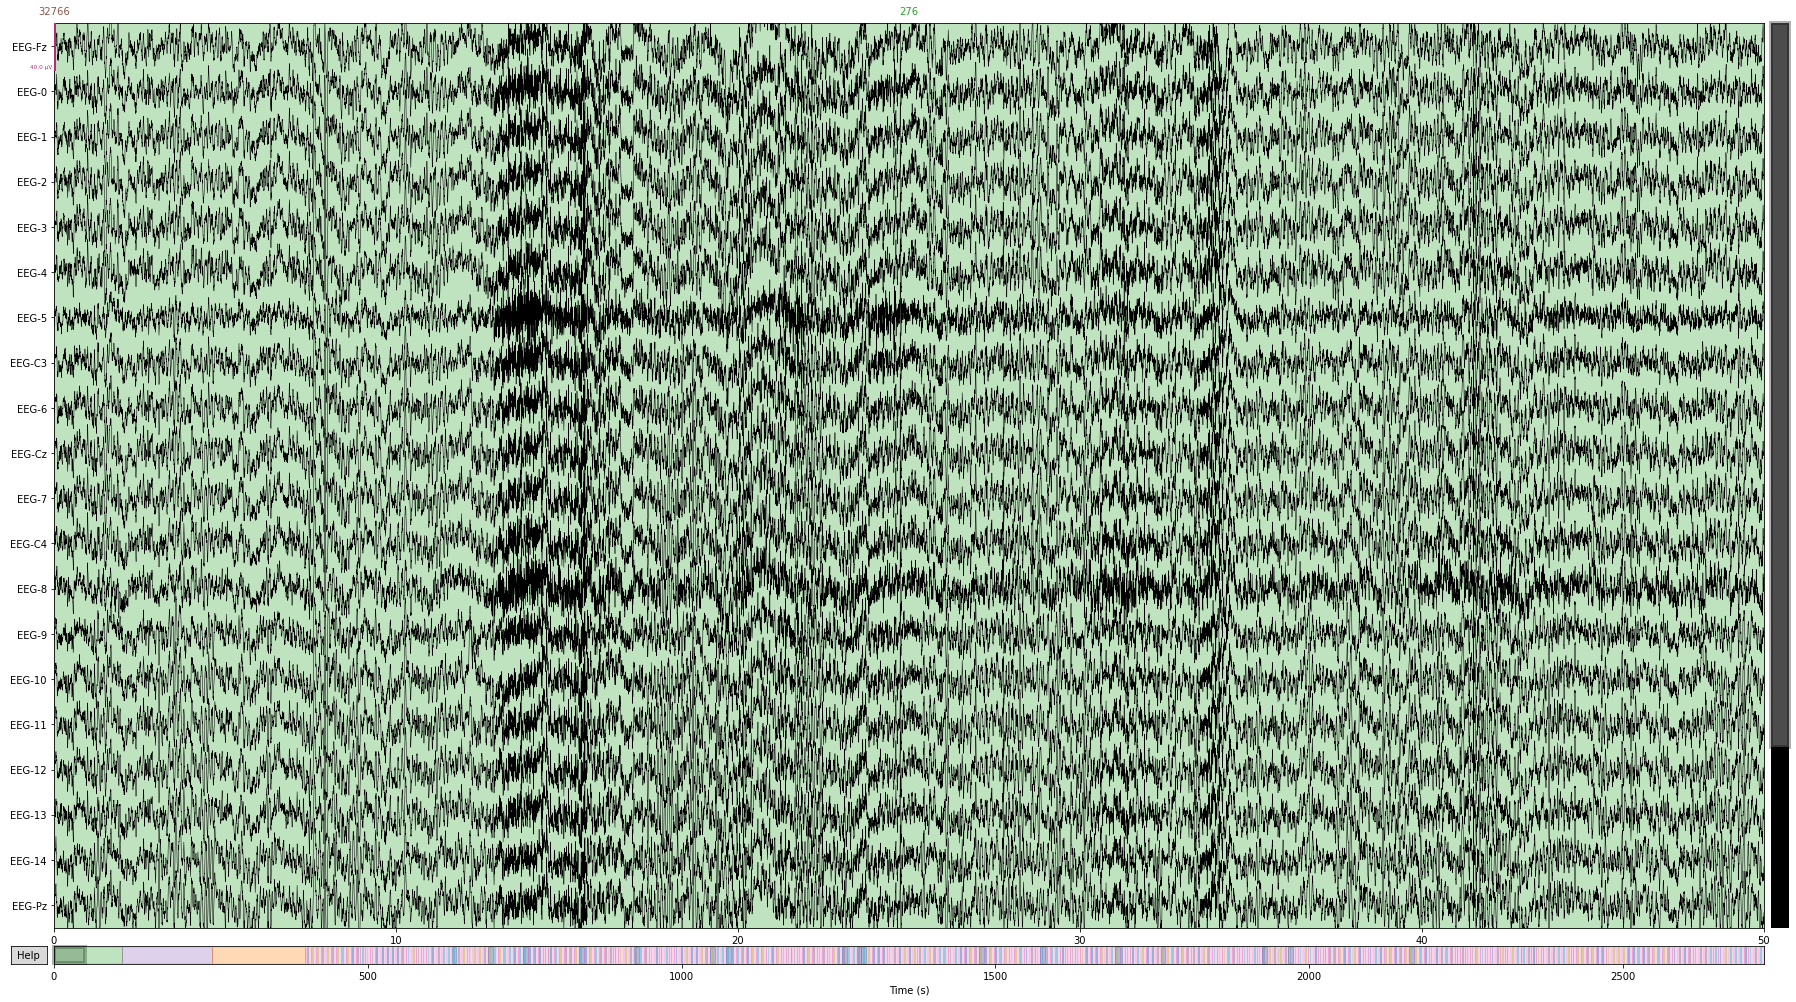

Reading S1_train-ica_2.fif ...
Isotrak not found
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (22 components)
    Zeroing out 3 ICA components
    Projecting back using 22 PCA components
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']


/tmp/ipykernel_148840/465843244.py:58: RuntimeWarning: This filename (S1_train-ica_2.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica = read_ica('S1_train-ica_2.fif')


In [38]:
#загружаем файл с обучающей выборкой, фильтруем 50 Гц, строим график и отмечаем плохие сегменты
file_name = 'DZ2/1/A07T.gdf'

container = mne.io.read_raw_gdf(file_name, preload=True)
container.notch_filter(50)

container.plot(duration = 50)

bad_onset = [811.5, 827.3, 1175.6, 1214, 1231, 
             1238, 1254.4, 1286.8, 1342.4, 1358,
             1366.4, 1431.2, 1473.6, 1480.4, 1528.8, 
             1536, 1552, 1554, 1578, 1601.2, 
             1642, 1721.6, 1769.2, 1884, 1899.6, 
             1907.6, 1916, 1923.6, 1939.6, 1948,
             1972.8, 2014, 2165.2, 2181.2, 2576.4]#[::3]
# bad_onset = [0,118,199,365,728.90,819.20,905.80,1156.30,1159.81,2213.50]
# bad_onset = []
container.annotations.append(onset=bad_onset, duration= 2, description='bad')

#отделяем EOG каналы от общей записи
eog = container.copy().pick(np.arange(22,25)).resample(50).get_data()
container = container.pick(np.arange(22))

if not Path('S1_train-ica_2.fif').exists():
    #делаем ICA
    to_ica = container.copy()
    to_ica.filter(2,35)

    ica = ICA(n_components=None, random_state=7,method = 'infomax',fit_params=dict(extended=True))
    ica.fit(to_ica)
    ica.save('S1_train-ica_2.fif')
    ica = read_ica('S1_train-ica_2.fif')

    #строим временные ряды независимых компонент
    ica.plot_sources(to_ica)

    #получаем временные ряды независимых компонент
    sources = ica.get_sources(to_ica).resample(50).get_data()


    #считаем взаимную информацию каждой независимой комопненты с ЭОГ-каналами
    MI = np.zeros((sources.shape[0],))
    for i in range(sources.shape[0]):
        for j in range(eog.shape[0]):
            MI[i] += np.sum(mir(eog[j,:10000][:,np.newaxis],sources[i,:10000]))

    del sources
    del to_ica

    #сортируем независимые компоненты по убыванию взаимной информации с ЭОГ и убираем первые три
    eog_idc = np.argsort(MI)[::-1][:3]
    ica.exclude = eog_idc.tolist()
    ica.save('S1_train-ica_2.fif')

else:
    ####
    #загружаем и применяем ICA
    ica = read_ica('S1_train-ica_2.fif')

container = ica.apply(container)


#список меток и времен их появления, а также имена меток
events,event_id = mne.events_from_annotations(container)

#имена меток, которые нас интересуют (left hand imagery, right hand, legs, tongue)
event_touse = [7,8,9,10]

#переименовываем каналы в соответствии со стандартной системой 10-20, создаем монтаж
new_names = {'EEG-Fz':'Fz','EEG-0':'FC3','EEG-1':'FC1','EEG-2':'FCz',\
             'EEG-3':'FC2','EEG-4':'FC4','EEG-5':'C5','EEG-C3':'C3',\
             'EEG-6':'C1','EEG-Cz':'Cz','EEG-7':'C2','EEG-C4':'C4','EEG-8':'C6',\
            'EEG-9':'CP3','EEG-10':'CP1','EEG-11':'CPz','EEG-12':'CP2',\
                'EEG-13':'CP4','EEG-14':'P1','EEG-Pz':'Pz','EEG-15':'P2','EEG-16':'POz'}

mne.rename_channels(container.info,new_names)
DIG = mne.channels.make_standard_montage('standard_1005')
container.info.set_montage(DIG)


#инициализация filter-bank csp с нарезанием данных по частотам от 4 до 40 Гц с шириной полосы - 4 Гц
freq_range = np.concatenate((np.arange(4,40,4)[:,np.newaxis],np.arange(8,44,4)[:,np.newaxis]),axis = 1)
fbcsp = fbCSP(event_touse,freq_range = freq_range,\
                 filters_idc = [0,1,-1,-2],dim_red = 19,n_features = 4,scale = 1e6)
   
#это инициализация fbCSP, реализующего простой CSP
#freq_range = np.array([[9,13]])
#fbcsp = fbCSP(event_touse,freq_range = freq_range,\
#                 filters_idc = [0,1,-1,-2],dim_red = 19,n_features = 4,scale = 1e6)
     

In [39]:
#обучаем csp
features,labels = fbcsp.fit(container,tmin=1,tmax=4)
# del container

Nclasses = len(event_touse)

#обучаем LDA и SVM с радиальной базисной функцией
lda = LDA()
lda.fit(np.concatenate(features,axis =1),labels)
svm = SVM(kernel = 'rbf')
svm.fit(np.concatenate(features,axis =1),labels)

#инициализируем и обучаем нейросеть
#nn = NN(0,16,16,4,lam=0.001,reg = 'l2') #for l2 - 0.01 #for l1 - 0.0001
#nn.learning(np.concatenate(features,axis =1),labels)
    

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Omitting 17500 of 681071 (2.57%) samples, retaining 663571 (97.43%) samples.
Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Loading data for 288 events and 751 original time points ...
3 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Loading data for 288 events and 751 original time points ...
3 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz


SVC()

In [40]:
#загружаем тестирующие данные, выполняем ту же предобработку, что и для обучающих
file_name = 'DZ2/1/A07E.gdf'

container_test = mne.io.read_raw_gdf(file_name, preload=True)
container_test.notch_filter(50)
container_test= container_test.pick(np.arange(22))
container_test = ica.apply(container_test)
events,event_id = mne.events_from_annotations(container_test)

Extracting EDF parameters from /home/dmitry/made/neurointerfaces/hw2/handout/MADE_neurointerfaces/DZ2/1/A07E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 673134  =      0.000 ...  2692.536 secs...


/home/dmitry/miniconda3/envs/neurointerfaces/lib/python3.9/site-packages/mne/io/edf/edf.py:1121: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/dmitry/miniconda3/envs/neurointerfaces/lib/python3.9/contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 sec)

Applying ICA to Raw instance
    Transforming to ICA space (22 components)
    Zeroing out 3 ICA components
    Projecting back using 22 PCA components
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']


##### a. Проводите настройку алгоритма и расчёт ковариационных матриц и весов классификатора на полной выборке с исходными длительностями реализаций  T0, а классификацию проводите на более коротких реализациях.

In [41]:
#передаем в функцию номер метки, соответствующей неизвестному классу
experiments = {'T0': (1, 4), 
               '0.8*T0': (1.3, 3.7),
               '0.7*T0': (1.45, 3.55),
               '0.6*T0': (1.6, 3.4),
               '0.5*T0': (1.75, 3.25)}
features_a = {k: fbcsp.apply(container_test, unknown_events=[7,], tmin=tmin, tmax=tmax)
              for k, (tmin, tmax) in experiments.items()}

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Loading data for 288 events and 751 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Loading data for 288 events and 751 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and

- Cutoffs at 24.00, 28.00 Hz: -6.02, -6.02 dB

Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Loading data for 288 events and 601 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 28 - 32 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 28.00, 32.00 Hz: -6.02, -6.02 dB

Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Loading data for 288 events and 601 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 32 - 36 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Fi

Setting up band-pass filter from 12 - 16 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 12.00, 16.00 Hz: -6.02, -6.02 dB

Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Loading data for 288 events and 451 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 16 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 16.00, 20.00 Hz: -6.02, -6.02 dB

Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Loading data for 288 events and 451 original time points ...
0 bad epochs d


IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 36.00, 40.00 Hz: -6.02, -6.02 dB

Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Loading data for 288 events and 375 original time points ...
0 bad epochs dropped


In [42]:
def evaluate(features, classifiers):
    accuracies = []
    for feature_name, feature_obj in features.items():
        print(feature_name)
        exp_name = feature_name.replace('_b', '')
        if exp_name in classifiers:
            lda, svm = classifiers[exp_name]
        else:
            lda, svm = classifiers['T0']
        #классифицируем признаки
        final_labels_svm = svm.predict(np.concatenate(feature_obj,axis = 1))
        final_labels_lda = lda.predict(np.concatenate(feature_obj,axis = 1))

        #final_labels_nn = nn.predict(np.concatenate(features,axis = 1))

        #загружаем правильные ответы метки
        convert = loadmat('DZ2/1/A07E.mat')
        real_labels= convert['classlabel'][:,0] + 6

        #точности для svm и lda
        accuracy_svm = np.mean(final_labels_svm == real_labels)
        accuracy_lda = np.mean(final_labels_lda == real_labels)

        print('SVM: ',accuracy_svm)
        print('LDA: ',accuracy_lda)

        accuracies.append(max(accuracy_svm, accuracy_lda))

        #accuracy_nn = np.mean(final_labels_nn == real_labels)


        #confusion matrix
        confusion = np.zeros((4,4))
        for i in range(7,11):
            for j in range(7,11):
                confusion[i-7,j-7] = np.sum(real_labels[np.isin(real_labels,i)]\
                            ==final_labels_lda[np.isin(real_labels,j)])
        plt.figure()
        plt.title(feature_name)
        plt.imshow(confusion,cmap= 'binary')
        plt.xlabel('real class')
        plt.ylabel('decoded class')
        plt.xticks([0,1,2,3],['LH','RH','F','T'])
        plt.yticks([0,1,2,3],['LH','RH','F','T'])
    return accuracies

T0
SVM:  0.7152777777777778
LDA:  0.7743055555555556
0.8*T0
SVM:  0.8055555555555556
LDA:  0.8159722222222222
0.7*T0
SVM:  0.8125
LDA:  0.8090277777777778
0.6*T0
SVM:  0.7569444444444444
LDA:  0.8020833333333334
0.5*T0
SVM:  0.6736111111111112
LDA:  0.7326388888888888
[0.77430556 0.81597222 0.8125     0.80208333 0.73263889]


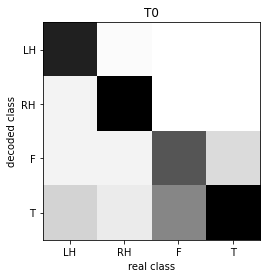

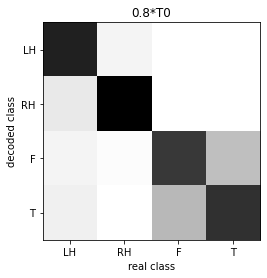

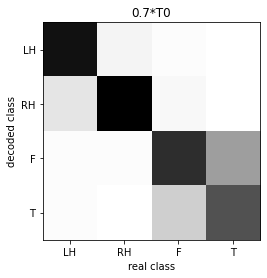

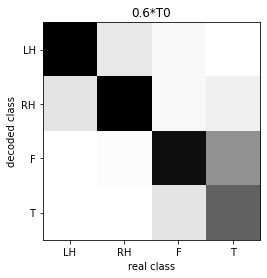

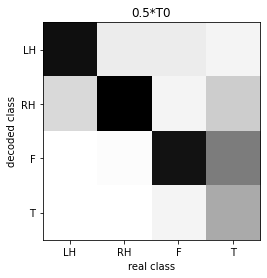

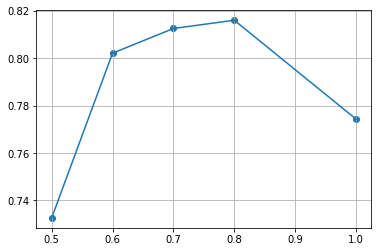

In [43]:
# for feat, classificator in zip(features)
accuracies_1a = evaluate(features_a, {'T0': (lda, svm)})
print(np.array(accuracies_1a))
plt.figure()
plt.plot([1.0, 0.8, 0.7, 0.6, 0.5], accuracies_1a)
plt.scatter([1.0, 0.8, 0.7, 0.6, 0.5], accuracies_1a)
plt.grid()
plt.savefig('acc_seg_length_a_bad_onsets_full.png')

##### b. Проводите настройку алгоритма и расчёт ковариационых матриц и весов классификатора на сегментах реализациях ограниченной длины. Классификацию проводите на сегментах реализации соответствующей длины

In [44]:
experiments = {'T0': (1, 4), 
               '0.8*T0': (1.3, 3.7),
               '0.7*T0': (1.45, 3.55),
               '0.6*T0': (1.6, 3.4),
               '0.5*T0': (1.75, 3.25)}


#инициализация filter-bank csp с нарезанием данных по частотам от 4 до 40 Гц с шириной полосы - 4 Гц
freq_range = np.concatenate((np.arange(4,40,4)[:,np.newaxis],np.arange(8,44,4)[:,np.newaxis]),axis = 1)

#обучаем csp
features_labels = {k: fbCSP(event_touse,
                            freq_range=freq_range,
                            filters_idc=[0,1,-1,-2],
                            dim_red=19,
                            n_features=4,
                            scale=1e6).fit(container,
                                           tmin=tmin,
                                           tmax=tmax)
                   for k, (tmin, tmax) in experiments.items()}
# del container

Nclasses = len(event_touse)

classifiers = {k: (LDA().fit(np.concatenate(features, axis=1), labels),
                   SVM(kernel = 'rbf').fit(np.concatenate(features, axis=1), labels))
               for k, (features, labels) in features_labels.items()}  

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Omitting 17500 of 681071 (2.57%) samples, retaining 663571 (97.43%) samples.
Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Loading data for 288 events and 751 original time points ...
3 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Loading data for 288 events and 751 original time points ...
3 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz



IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 24.00, 28.00 Hz: -6.02, -6.02 dB

Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Loading data for 288 events and 601 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 28 - 32 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 28.00, 32.00 Hz: -6.02, -6.02 dB

Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Loading data for 288 events and 601 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous se

- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 12.00 Hz: -6.02, -6.02 dB

Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Loading data for 288 events and 451 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 12 - 16 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 12.00, 16.00 Hz: -6.02, -6.02 dB

Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Loading data for 288 events and 451 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 16 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (

- Filter order 16 (effective, after forward-backward)
- Cutoffs at 32.00, 36.00 Hz: -6.02, -6.02 dB

Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Loading data for 288 events and 375 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 36 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 36.00, 40.00 Hz: -6.02, -6.02 dB

Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Loading data for 288 events and 375 original time points ...
0 bad epochs dropped


In [45]:
features_b = {k: fbcsp.apply(container_test,
                             unknown_events=[7,],
                             tmin=experiments[k][0],
                             tmax=experiments[k][1])
              for k, (lda, svm) in classifiers.items()}

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Loading data for 288 events and 751 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Loading data for 288 events and 751 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and

- Cutoffs at 24.00, 28.00 Hz: -6.02, -6.02 dB

Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Loading data for 288 events and 601 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 28 - 32 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 28.00, 32.00 Hz: -6.02, -6.02 dB

Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Loading data for 288 events and 601 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 32 - 36 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Fi

Setting up band-pass filter from 12 - 16 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 12.00, 16.00 Hz: -6.02, -6.02 dB

Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Loading data for 288 events and 451 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 16 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 16.00, 20.00 Hz: -6.02, -6.02 dB

Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Loading data for 288 events and 451 original time points ...
0 bad epochs d


IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 36.00, 40.00 Hz: -6.02, -6.02 dB

Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Loading data for 288 events and 375 original time points ...
0 bad epochs dropped


T0
SVM:  0.7152777777777778
LDA:  0.7743055555555556
0.8*T0
SVM:  0.4201388888888889
LDA:  0.3611111111111111
0.7*T0
SVM:  0.34375
LDA:  0.3055555555555556
0.6*T0
SVM:  0.3020833333333333
LDA:  0.2534722222222222
0.5*T0
SVM:  0.3159722222222222
LDA:  0.2604166666666667
[0.77430556 0.42013889 0.34375    0.30208333 0.31597222]


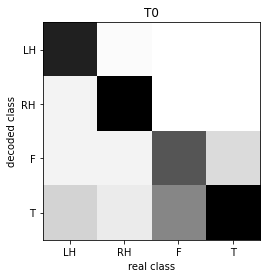

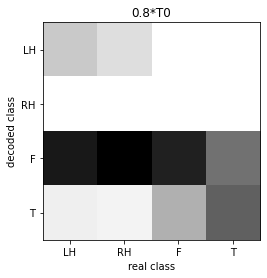

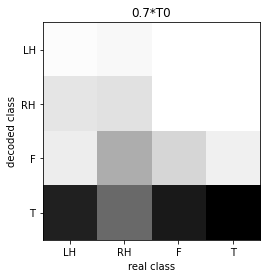

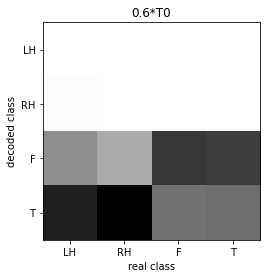

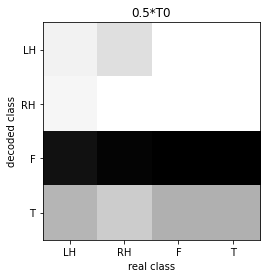

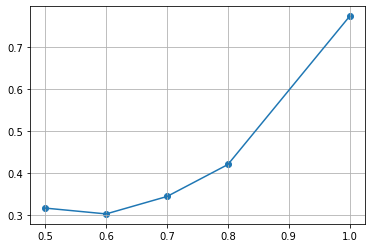

In [47]:
accuracies_1b = evaluate(features_b, classifiers)
print(np.array(accuracies_1b))
plt.figure()
plt.plot([1.0, 0.8, 0.7, 0.6, 0.5], accuracies_1b)
plt.scatter([1.0, 0.8, 0.7, 0.6, 0.5], accuracies_1b)
plt.grid()
plt.savefig('acc_seg_length_b_bad_onsets_full.png')

In [33]:
from scipy.io import savemat

In [34]:
accuracies_1a = np.array(accuracies_1a)
accuracies_1b = np.array(accuracies_1b)
max_acc = 0.55 # according to task2.ipynb
print(accuracies_1a)
print(accuracies_1b)
print(max_acc)

[0.74652778 0.77430556 0.79166667 0.79861111 0.73958333]
[0.74652778 0.54861111 0.39236111 0.40625    0.39930556]
0.55


In [35]:
handout_1 = {'Task1a': accuracies_1a, 'Task1b': accuracies_1b, 'Task2': max_acc} # see task 2 in task2.ipynb
savemat('Klestov_Dmitry_DZ2.mat', handout_1)
print(handout_1)

{'Task1a': array([0.74652778, 0.77430556, 0.79166667, 0.79861111, 0.73958333]), 'Task1b': array([0.74652778, 0.54861111, 0.39236111, 0.40625   , 0.39930556]), 'Task2': 0.55}
